- prediction of outcome from co-variates
 - select appropriate ml algos
- with cross-val
- use some explanatory factor like how much treatment is affecting outcome for each ml method
- restarted from https://github.com/adibzaman/RCHE-Data-Science/blob/master/adib2149/delirium_study/machine_learning/xgb.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('delirium_data_cleaned.csv')

In [5]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'sex', 'age', 'race',
       'icd9_codes', 'sofa', 'apsiii', 'surgery', 'pneumonia', 'sepsis',
       'dementia', 'alzheimers', 'depression', 'anxiety', 'met_acidosis',
       'airway_obs', 'copd', 'liver_disease', 'heart_disease', 'mechvent',
       'mechvent_count', 'drug_group', 'drug_categories_distinct_count',
       'drug_timelength', 'death_hosp', 'death_timeline', 'los_days',
       'time_to_mechvent', 'time_in_mechvent'],
      dtype='object')

In [6]:
data = data.rename({'drug_categories_distinct_count':'drug_cat_count'}, axis=1)

In [7]:
data = data.drop('icd9_codes', 1)

In [8]:
obj_col_list = data.select_dtypes(include="object").columns
print (obj_col_list)

Index(['sex', 'drug_group'], dtype='object')


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for feature in obj_col_list:
    data[feature] = le.fit_transform(data[feature].astype(str))

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1671 non-null   int64  
 1   hadm_id           1671 non-null   int64  
 2   icustay_id        1671 non-null   int64  
 3   sex               1671 non-null   int64  
 4   age               1671 non-null   float64
 5   race              1671 non-null   int64  
 6   sofa              1671 non-null   int64  
 7   apsiii            1671 non-null   int64  
 8   surgery           1671 non-null   int64  
 9   pneumonia         1671 non-null   int64  
 10  sepsis            1671 non-null   int64  
 11  dementia          1671 non-null   int64  
 12  alzheimers        1671 non-null   int64  
 13  depression        1671 non-null   int64  
 14  anxiety           1671 non-null   int64  
 15  met_acidosis      1671 non-null   int64  
 16  airway_obs        1671 non-null   int64  


In [10]:
data.sample(5)

,subject_id,hadm_id,icustay_id,sex,age,race,sofa,apsiii,surgery,pneumonia,sepsis,dementia,alzheimers,depression,anxiety,met_acidosis,airway_obs,copd,liver_disease,heart_disease,mechvent,mechvent_count,drug_group,drug_cat_count,drug_timelength,death_hosp,death_timeline,los_days,time_to_mechvent,time_in_mechvent
400,20133,109649,265155,0,50.44,2,4,46,0,1,0,0,0,0,0,0,0,0,0,1,1,1,2,3,1808,0,4,6.1538,0.372917,38.616667
1572,92137,179704,238410,1,65.86,1,0,17,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,3,13,0,-1,5.2278,8.663194,12.866667
1067,60168,156566,212012,1,57.76,1,2,37,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,22,0,-1,2.0208,0.500000,9.000000
976,54514,125949,281118,0,53.18,1,5,48,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,17,0,1,7.6369,2.554167,64.983333
1340,77131,120073,217745,1,55.02,2,12,62,1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,4,1,1,5.2559,5.139583,111.000000


In [11]:
data.drug_group.unique()

array([0, 1, 2])

In [12]:
heatmap_data = data.iloc[:,3:].corr()
display(heatmap_data)

,sex,age,race,sofa,apsiii,surgery,pneumonia,sepsis,dementia,alzheimers,depression,anxiety,met_acidosis,airway_obs,copd,liver_disease,heart_disease,mechvent,mechvent_count,drug_group,drug_cat_count,drug_timelength,death_hosp,death_timeline,los_days,time_to_mechvent,time_in_mechvent
sex,1.000000,-0.083335,-0.012508,0.049364,-0.048803,0.064539,0.002787,0.015452,-0.067310,-0.036092,-0.072435,-0.047161,0.031570,-0.041925,-0.038599,-0.027526,-0.012008,0.109803,0.057387,-0.112403,0.039341,0.024605,0.009150,-0.005386,0.041031,0.056821,0.043451
age,-0.083335,1.000000,-0.082842,-0.089984,0.017348,-0.152986,-0.104405,-0.104186,0.174010,0.194070,-0.098075,-0.112251,-0.075297,0.067920,0.062267,-0.156762,0.330111,-0.220667,-0.139211,0.019787,-0.056371,0.067467,0.028144,0.204262,-0.179684,-0.132716,-0.194369
race,-0.012508,-0.082842,1.000000,0.046250,0.056502,-0.057639,0.028451,0.004204,-0.010408,-0.014036,0.037070,-0.017227,0.016818,-0.032777,-0.034340,0.008641,-0.033719,-0.090046,-0.048495,-0.009684,-0.027695,-0.004337,-0.025096,0.036003,-0.007651,-0.036200,-0.026243
sofa,0.049364,-0.089984,0.046250,1.000000,0.697159,0.091613,0.132485,0.315766,-0.012259,-0.024821,-0.017641,-0.009772,0.070292,0.024268,0.016908,0.241682,0.110185,0.251103,0.156888,0.001231,0.070897,-0.069457,0.254459,0.010646,0.230648,0.176083,0.212084
apsiii,-0.048803,0.017348,0.056502,0.697159,1.000000,0.030308,0.117003,0.299114,-0.022138,-0.012091,-0.021239,-0.045567,0.091036,0.049206,0.050285,0.198485,0.132265,0.069689,0.063704,0.023928,0.060813,-0.091897,0.286774,0.045834,0.193441,0.135441,0.170734
surgery,0.064539,-0.152986,-0.057639,0.091613,0.030308,1.000000,0.079808,0.088907,-0.064066,-0.077514,-0.038725,-0.042732,0.038673,-0.014216,0.005352,0.051312,-0.060523,0.210296,0.173601,0.001875,0.023732,0.014935,0.050231,-0.044661,0.178490,0.117664,0.175685
pneumonia,0.002787,-0.104405,0.028451,0.132485,0.117003,0.079808,1.000000,0.178301,-0.053407,-0.072502,0.016278,0.021176,0.084692,-0.037435,-0.048714,0.067165,0.084820,0.157412,0.205479,0.047811,0.106139,-0.006502,0.115547,0.046900,0.275957,0.107933,0.256820
sepsis,0.015452,-0.104186,0.004204,0.315766,0.299114,0.088907,0.178301,1.000000,-0.034030,-0.037430,0.039946,0.016297,0.124036,0.031514,0.005341,0.142511,0.049423,0.041174,0.059174,0.014817,0.017801,-0.111204,0.253962,-0.021835,0.203676,0.135503,0.212778
dementia,-0.067310,0.174010,-0.010408,-0.012259,-0.022138,-0.064066,-0.053407,-0.034030,1.000000,0.557039,0.001032,0.019916,-0.009564,-0.048592,-0.027751,-0.023470,0.017464,-0.094235,-0.070747,0.077973,0.002903,-0.020021,0.019079,0.000601,-0.079787,-0.046196,-0.066984
alzheimers,-0.036092,0.194070,-0.014036,-0.024821,-0.012091,-0.077514,-0.072502,-0.037430,0.557039,1.000000,-0.022570,-0.028101,-0.030764,-0.001564,-0.013193,-0.042800,0.027389,-0.095704,-0.082665,0.085093,0.025238,-0.021983,-0.031831,0.011193,-0.090773,-0.045760,-0.074480


In [13]:
corr_mat = data.iloc[:,3:].corr()
corr_mat = corr_mat[corr_mat.replace(1,0).gt(0.6).any(axis=1)]
corr_mat

,sex,age,race,sofa,apsiii,surgery,pneumonia,sepsis,dementia,alzheimers,depression,anxiety,met_acidosis,airway_obs,copd,liver_disease,heart_disease,mechvent,mechvent_count,drug_group,drug_cat_count,drug_timelength,death_hosp,death_timeline,los_days,time_to_mechvent,time_in_mechvent
sofa,0.049364,-0.089984,0.046250,1.000000,0.697159,0.091613,0.132485,0.315766,-0.012259,-0.024821,-0.017641,-0.009772,0.070292,0.024268,0.016908,0.241682,0.110185,0.251103,0.156888,0.001231,0.070897,-0.069457,0.254459,0.010646,0.230648,0.176083,0.212084
apsiii,-0.048803,0.017348,0.056502,0.697159,1.000000,0.030308,0.117003,0.299114,-0.022138,-0.012091,-0.021239,-0.045567,0.091036,0.049206,0.050285,0.198485,0.132265,0.069689,0.063704,0.023928,0.060813,-0.091897,0.286774,0.045834,0.193441,0.135441,0.170734
airway_obs,-0.041925,0.067920,-0.032777,0.024268,0.049206,-0.014216,-0.037435,0.031514,-0.048592,-0.001564,0.018504,-0.021792,-0.030053,1.000000,0.917177,-0.034758,0.038670,-0.040808,-0.010949,0.067747,0.021320,-0.009467,0.012168,0.043424,-0.015606,-0.030499,-0.003123
copd,-0.038599,0.062267,-0.034340,0.016908,0.050285,0.005352,-0.048714,0.005341,-0.027751,-0.013193,0.025412,-0.025049,-0.010990,0.917177,1.000000,-0.045669,0.036310,-0.033857,-0.012371,0.051225,0.004289,0.011111,0.004582,0.058813,-0.020407,-0.035511,0.002668
mechvent_count,0.057387,-0.139211,-0.048495,0.156888,0.063704,0.173601,0.205479,0.059174,-0.070747,-0.082665,-0.031484,0.029702,0.063094,-0.010949,-0.012371,0.003024,0.085259,0.571517,1.000000,-0.032184,0.169488,-0.014105,-0.000937,-0.073621,0.671994,0.158041,0.403615
drug_timelength,0.024605,0.067467,-0.004337,-0.069457,-0.091897,0.014935,-0.006502,-0.111204,-0.020021,-0.021983,-0.049783,-0.041765,-0.058358,-0.009467,0.011111,-0.026688,0.026576,-0.020535,-0.014105,-0.038247,0.012425,1.000000,-0.141978,0.650299,-0.011851,-0.008685,-0.011736
death_timeline,-0.005386,0.204262,0.036003,0.010646,0.045834,-0.044661,0.046900,-0.021835,0.000601,0.011193,-0.058450,-0.073531,-0.023782,0.043424,0.058813,-0.006019,0.107255,-0.108546,-0.073621,0.022773,-0.014138,0.650299,0.045418,1.000000,-0.047407,0.009938,-0.048962
los_days,0.041031,-0.179684,-0.007651,0.230648,0.193441,0.178490,0.275957,0.203676,-0.079787,-0.090773,-0.060493,-0.002102,0.111341,-0.015606,-0.020407,0.057562,0.119978,0.431731,0.671994,-0.031394,0.217696,-0.011851,0.082059,-0.047407,1.000000,0.139354,0.681153
time_in_mechvent,0.043451,-0.194369,-0.026243,0.212084,0.170734,0.175685,0.256820,0.212778,-0.066984,-0.074480,-0.046426,0.024303,0.110993,-0.003123,0.002668,0.065759,0.046726,0.423275,0.403615,-0.037819,0.143420,-0.011736,0.064700,-0.048962,0.681153,0.143690,1.000000


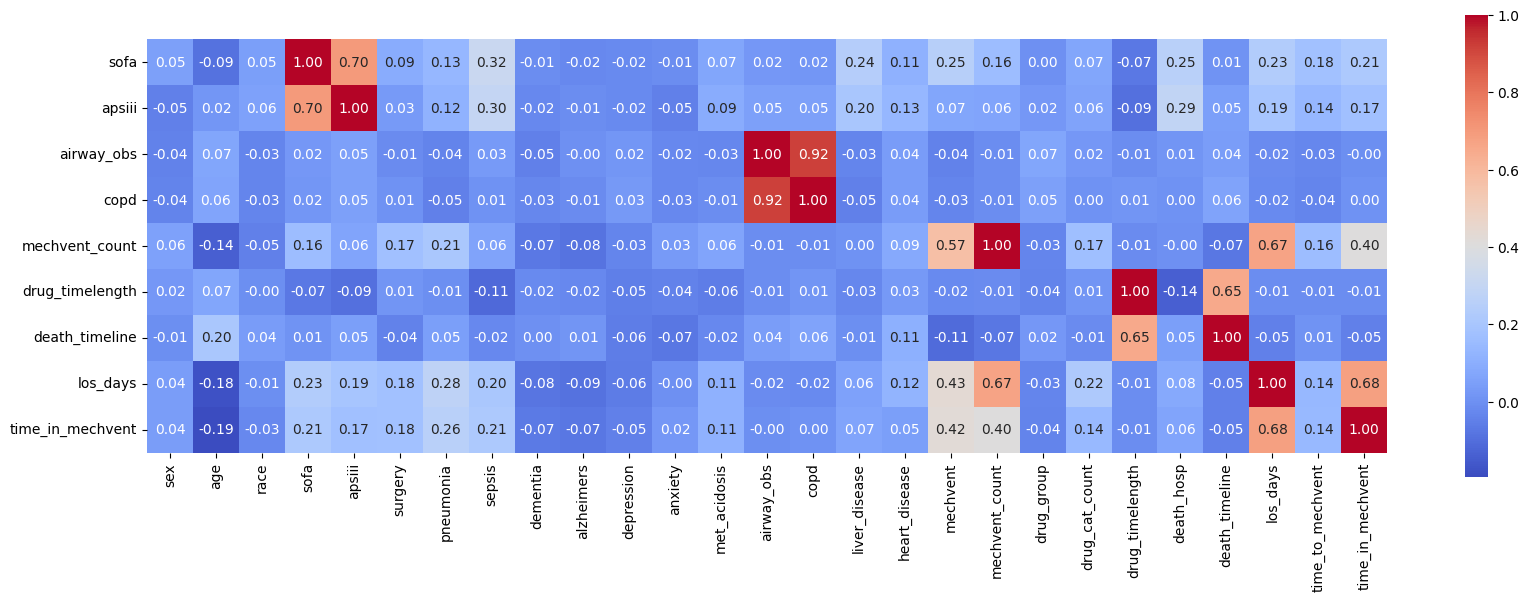

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr_mat, cmap='coolwarm', square=True, annot=True, fmt=".2f")
# plt.show()
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

# create train and test datasets

In [15]:
X, y = data.iloc[:,3:-5], data.iloc[:,-5:-4]

In [16]:
print(X.columns)
print(X.shape)
X.sample(5)

Index(['sex', 'age', 'race', 'sofa', 'apsiii', 'surgery', 'pneumonia',
       'sepsis', 'dementia', 'alzheimers', 'depression', 'anxiety',
       'met_acidosis', 'airway_obs', 'copd', 'liver_disease', 'heart_disease',
       'mechvent', 'mechvent_count', 'drug_group', 'drug_cat_count',
       'drug_timelength'],
      dtype='object')
(1671, 22)


,sex,age,race,sofa,apsiii,surgery,pneumonia,sepsis,dementia,alzheimers,depression,anxiety,met_acidosis,airway_obs,copd,liver_disease,heart_disease,mechvent,mechvent_count,drug_group,drug_cat_count,drug_timelength
1383,1,90.00,1,7,61,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,114
382,0,64.83,1,7,51,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,155
274,1,90.00,1,9,74,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,8
1339,1,55.02,2,8,51,1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,9
1210,1,88.21,1,4,36,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,37


In [17]:
print(y.columns)
print(y.shape)
y.sample(5)

Index(['death_hosp'], dtype='object')
(1671, 1)


,death_hosp
485,0
488,0
1627,0
35,0
888,0


In [18]:
# https://stackoverflow.com/a/76016993/6720181

In [19]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, RocCurveDisplay, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [20]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [21]:
# Create models
models = [LogisticRegression(), SVC(kernel='linear', probability=True), SVC(kernel='rbf', probability=True), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), MLPClassifier()]
names = ["Logistic Regression", "SVM (Linear Kernel)", "SVM (Gaussian Kernel)", "Naive Bayes", "Decision Tree", "Random Forest", "XGBoost", "Neural Network"]

# models = [LogisticRegression()]
# names = ["LR"]

# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

In [22]:
for name, model in zip(names, models):
    # Perform 10-fold cross-validation with custom scoring metrics
    calc_score = cross_validate(model, X, y, cv=10, scoring=scoring, return_estimator=True)

    print(name)
    print("Accuracy:", round(calc_score['test_accuracy'].mean(), 3))
    print("Precision:", round(calc_score['test_precision'].mean(), 3))
    print("Recall:", round(calc_score['test_recall'].mean(), 3))
    print("F1-score:", round(calc_score['test_f1_score'].mean(), 3))
    print("=====================")
    
    # just using the estimator of the last fold of cross validation, and the whole datatset
    y_pred = calc_score['estimator'][9].predict_proba(X)[::,1] 
    
    # calculate fpr tpr and auc for the graph
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    
    # append valuesfor future use
    result_table = result_table.append({'classifiers':name,
                                        'accuracy': calc_score['test_accuracy'],
                                        'precision': calc_score['test_precision'],
                                        'recall': calc_score['test_recall'],
                                        'f1_score': calc_score['test_f1_score'],
                                        'fpr': fpr, 
                                        'tpr': tpr, 
                                        'auc': auc
                                       }, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

Logistic Regression
Accuracy: 0.893
Precision: 0.872
Recall: 0.893
F1-score: 0.873
SVM (Linear Kernel)
Accuracy: 0.891
Precision: 0.794
Recall: 0.891
F1-score: 0.84
SVM (Gaussian Kernel)
Accuracy: 0.891
Precision: 0.794
Recall: 0.891
F1-score: 0.84
Naive Bayes
Accuracy: 0.791
Precision: 0.884
Recall: 0.791
F1-score: 0.823
Decision Tree
Accuracy: 0.85
Precision: 0.865
Recall: 0.85
F1-score: 0.857
Random Forest
Accuracy: 0.906
Precision: 0.893
Recall: 0.906
F1-score: 0.878
XGBoost
Accuracy: 0.893
Precision: 0.876
Recall: 0.893
F1-score: 0.878
Neural Network
Accuracy: 0.896
Precision: 0.88
Recall: 0.896
F1-score: 0.88


# Feature Importance of Random Forest Classifier

In [23]:
from sklearn.inspection import permutation_importance

calc_score = cross_validate(RandomForestClassifier(), X, y, cv=10, scoring=scoring, return_estimator=True)
forest = calc_score['estimator'][9]

result = permutation_importance(forest, X, y, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

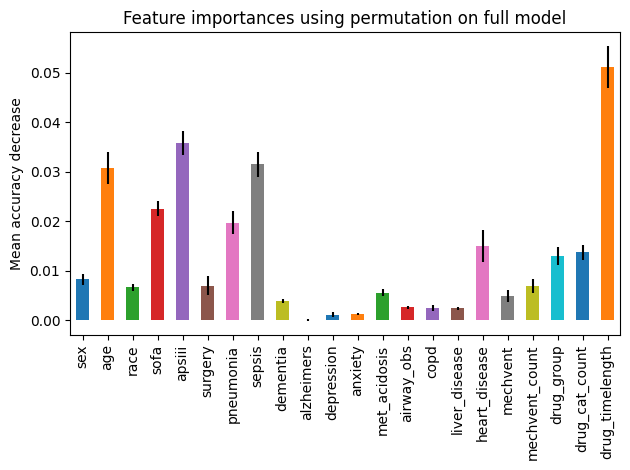

In [24]:
fig, ax = plt.subplots()
palette = sns.color_palette(None, 22)

forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color=palette.as_hex())
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [25]:
fig.savefig('feature_imp.png')

# Draw Metrics

In [26]:
import scipy.stats
from scipy import interp
from statistics import mean

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2, n-1)
    return h

In [27]:
mean_confidence_interval(result_table.iloc[0,4])

0.01650065102310656

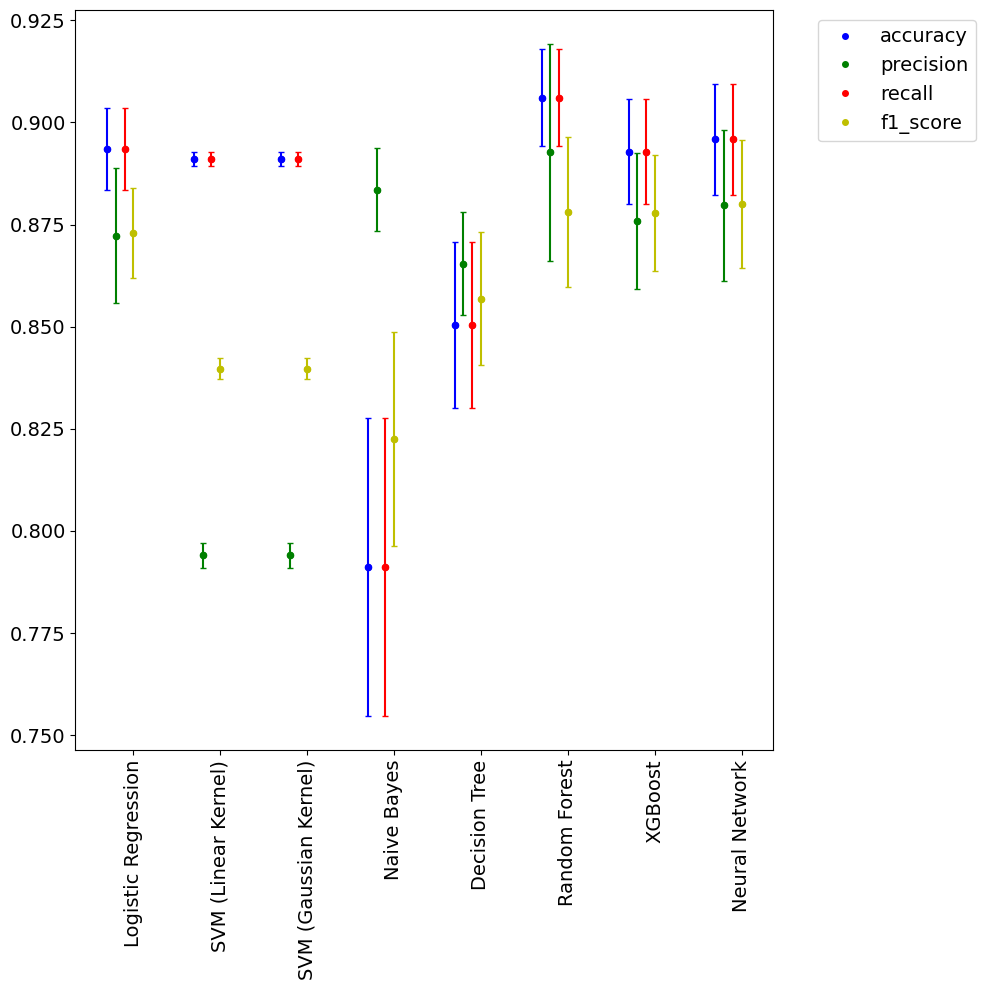

In [28]:
metrics = ['accuracy','precision','recall','f1_score']
colors = ["b","g","r","y"]

x_old = np.arange(3, 4*(len(names)),4)
x = np.arange(1.8, 4*(len(names)),4)
count = 0

x_ticks = names   

fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

l = 0

scale_factor = 5

for metric in metrics:
    y = []
    err = []
    for index, row in result_table.iterrows():
        y.append(mean(row[metric]))
        err.append(mean_confidence_interval(row[metric]))
    
    ax1.scatter(x, y, c=colors[l], s=20, zorder=3)
    ax1.errorbar(x, y, err, capsize=2,color=colors[l],linestyle="None",marker="o", markersize=4,label=metric)
    
    l += 1
    x += 0.4

    
handles, labels = ax1.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax1.legend(handles, labels, loc='upper left',numpoints=1,prop={'size':14},bbox_to_anchor=(1.05, 1))

plt.xticks(x_old, x_ticks, rotation=90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [29]:
fig.savefig('metrics.png')

# ROC Curve

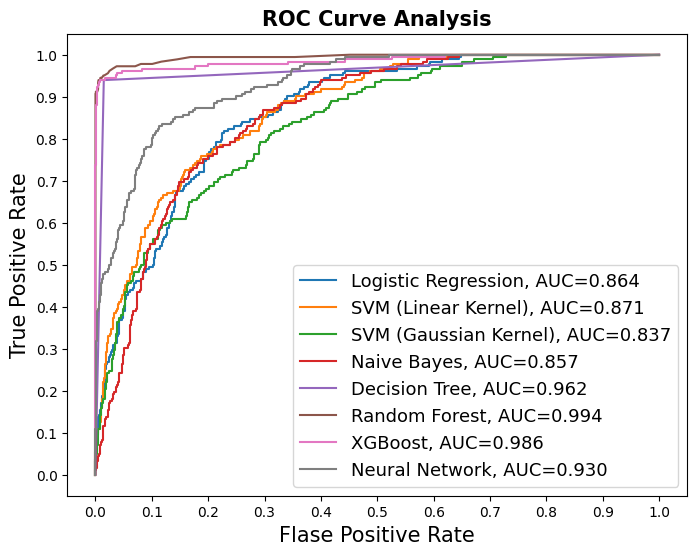

In [30]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
# plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [31]:
fig.savefig('multiple_roc_curve.png')